In [1]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

# only needed for tutorial, monkey patches visualization
sys.path.append('..')
import open3d_tutorial as o3dtut
# change to True if you want to interact with the visualization windows
o3dtut.interactive = not "CI" in os.environ

# Surface reconstruction

In many scenarios we want to generate a dense 3D geometry, i.e., a triangle mesh. However, from a multi-view stereo method, or a depth sensor we only obtain an unstructured point cloud. To get a triangle mesh from this unstructured input we need to perform surface reconstruction. In the literature there exists a couple of methods and Open3D currently implements the following:

- Alpha shapes [\[Edelsbrunner1983\]](../reference.html#Edelsbrunner1983)
- Ball pivoting [\[Bernardini1999\]](../reference.html#Bernardini1999)
- Poisson surface reconstruction [\[Kazhdan2006\]](../reference.html#Kazhdan2006)

## Alpha shapes
The alpha shape [\[Edelsbrunner1983\]](../reference.html#Edelsbrunner1983) is a generalization of a convex hull. As described [here](https://graphics.stanford.edu/courses/cs268-11-spring/handouts/AlphaShapes/as_fisher.pdf)  one can intuitively
think of an alpha shape as the following: Imagine a huge mass of ice cream containing the points $S$ as hard chocolate pieces. Using one of these sphere-formed ice cream spoons we carve out all parts of the ice cream block we can reach without bumping into chocolate pieces, thereby even carving out holes in the inside (e.g., parts not reachable by simply moving the
spoon from the outside). We will eventually end up with a (not necessarily convex) object bounded by caps, arcs and points. If we now straighten all round faces to triangles and line segments, we have an intuitive description of what is called the alpha shape of $S$.

Open3D implements the method `create_from_point_cloud_alpha_shape` that involves the tradeoff parameter `alpha`.

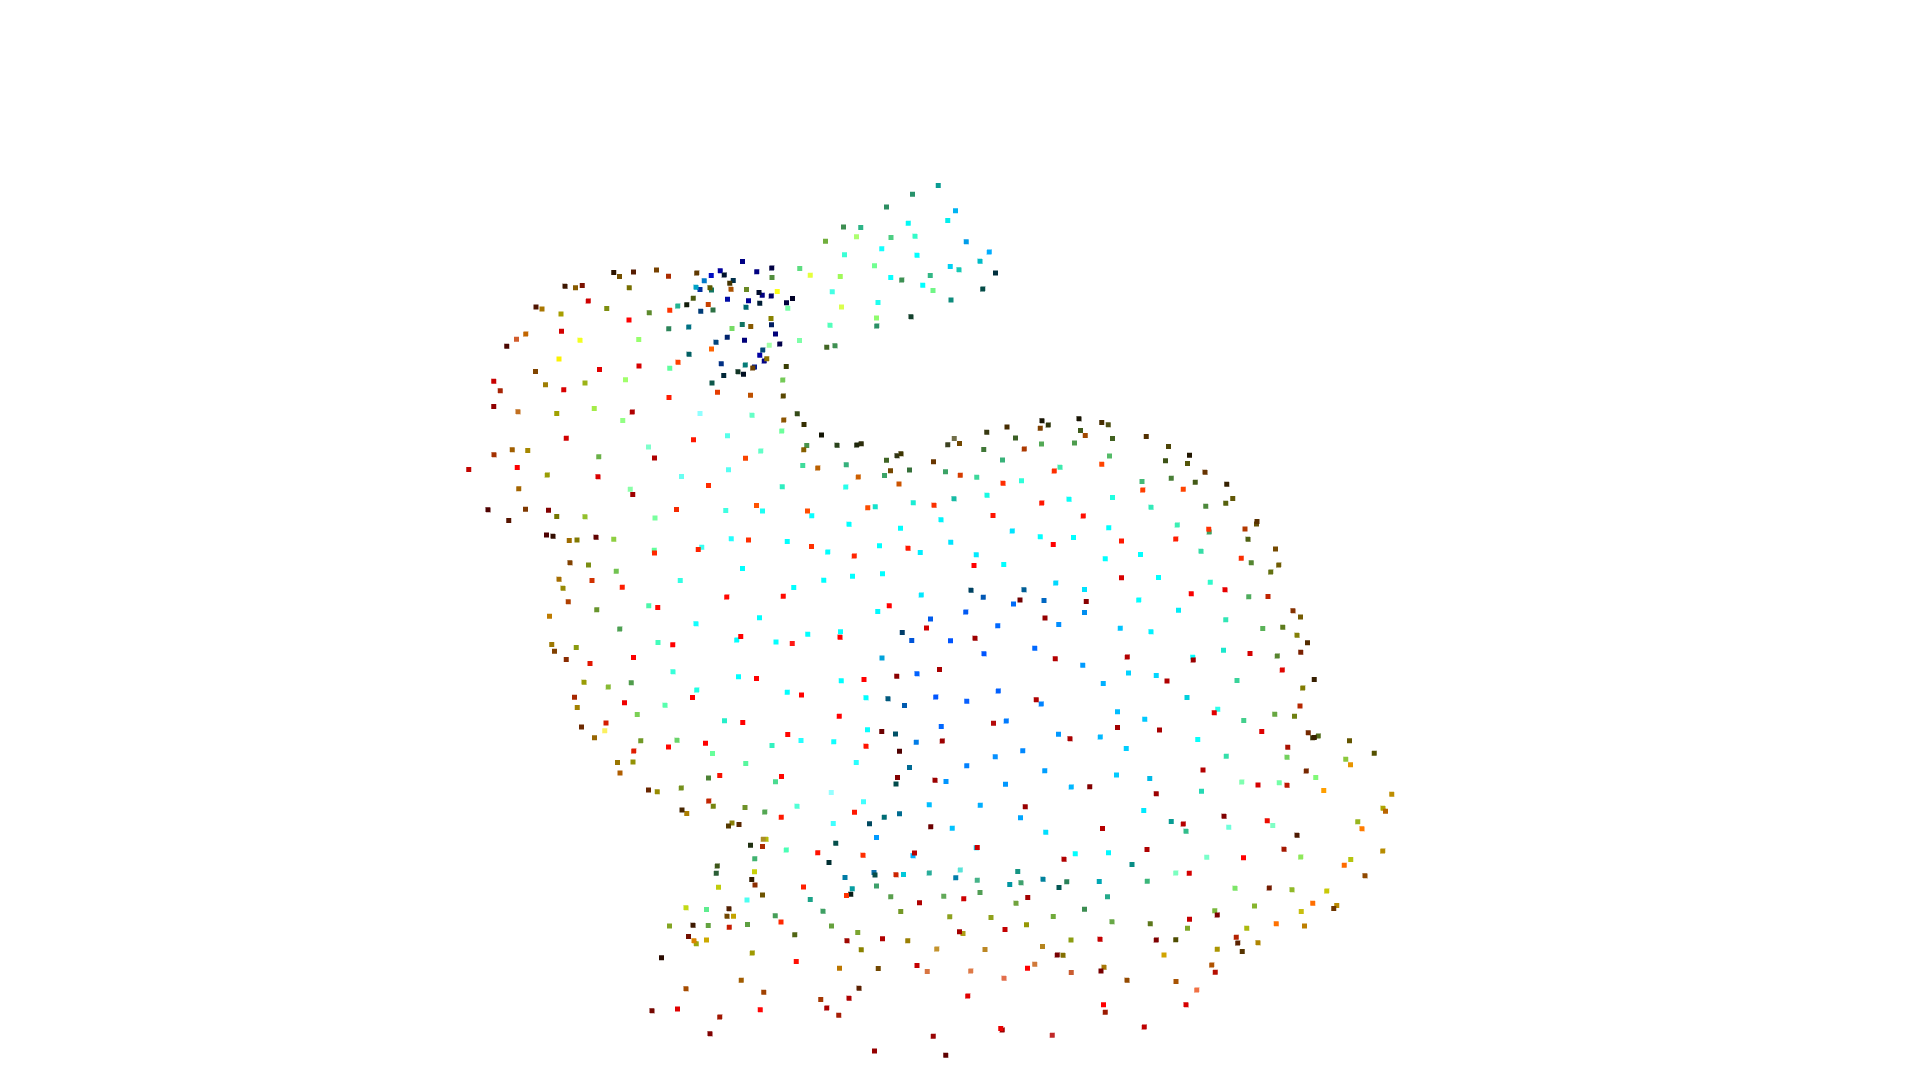

alpha=0.030


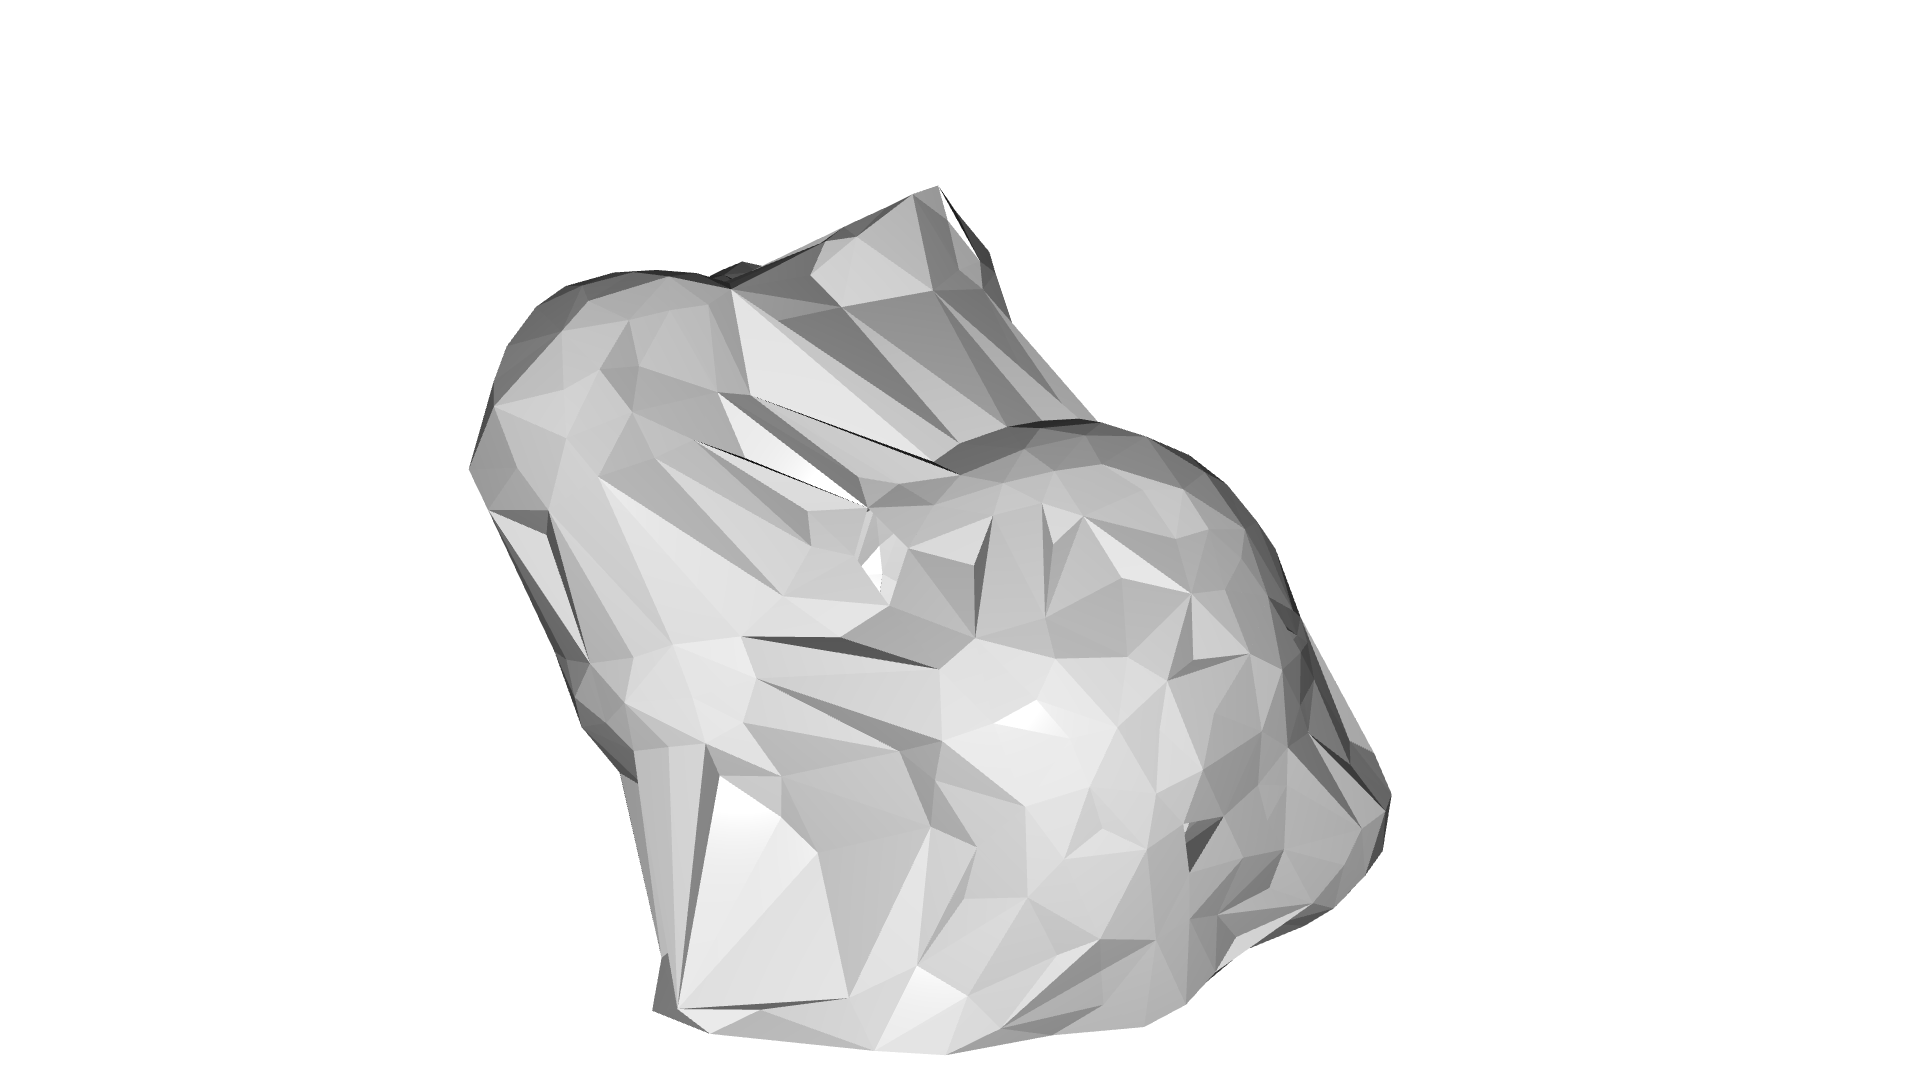

In [2]:
mesh = o3dtut.get_bunny_mesh()
pcd = mesh.sample_points_poisson_disk(750)
o3d.visualization.draw_geometries([pcd])
alpha = 0.03
print(f"alpha={alpha:.3f}")
mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(pcd, alpha)
mesh.compute_vertex_normals()
o3d.visualization.draw_geometries([mesh], mesh_show_back_face=True)

The implementation is based on the convex hull of the point cloud. If we want to compute multiple alpha shapes from a given point cloud, then we can save some computation by only computing the convex hull once and pass it to `create_from_point_cloud_alpha_shape`.

alpha=0.500


alpha=0.136


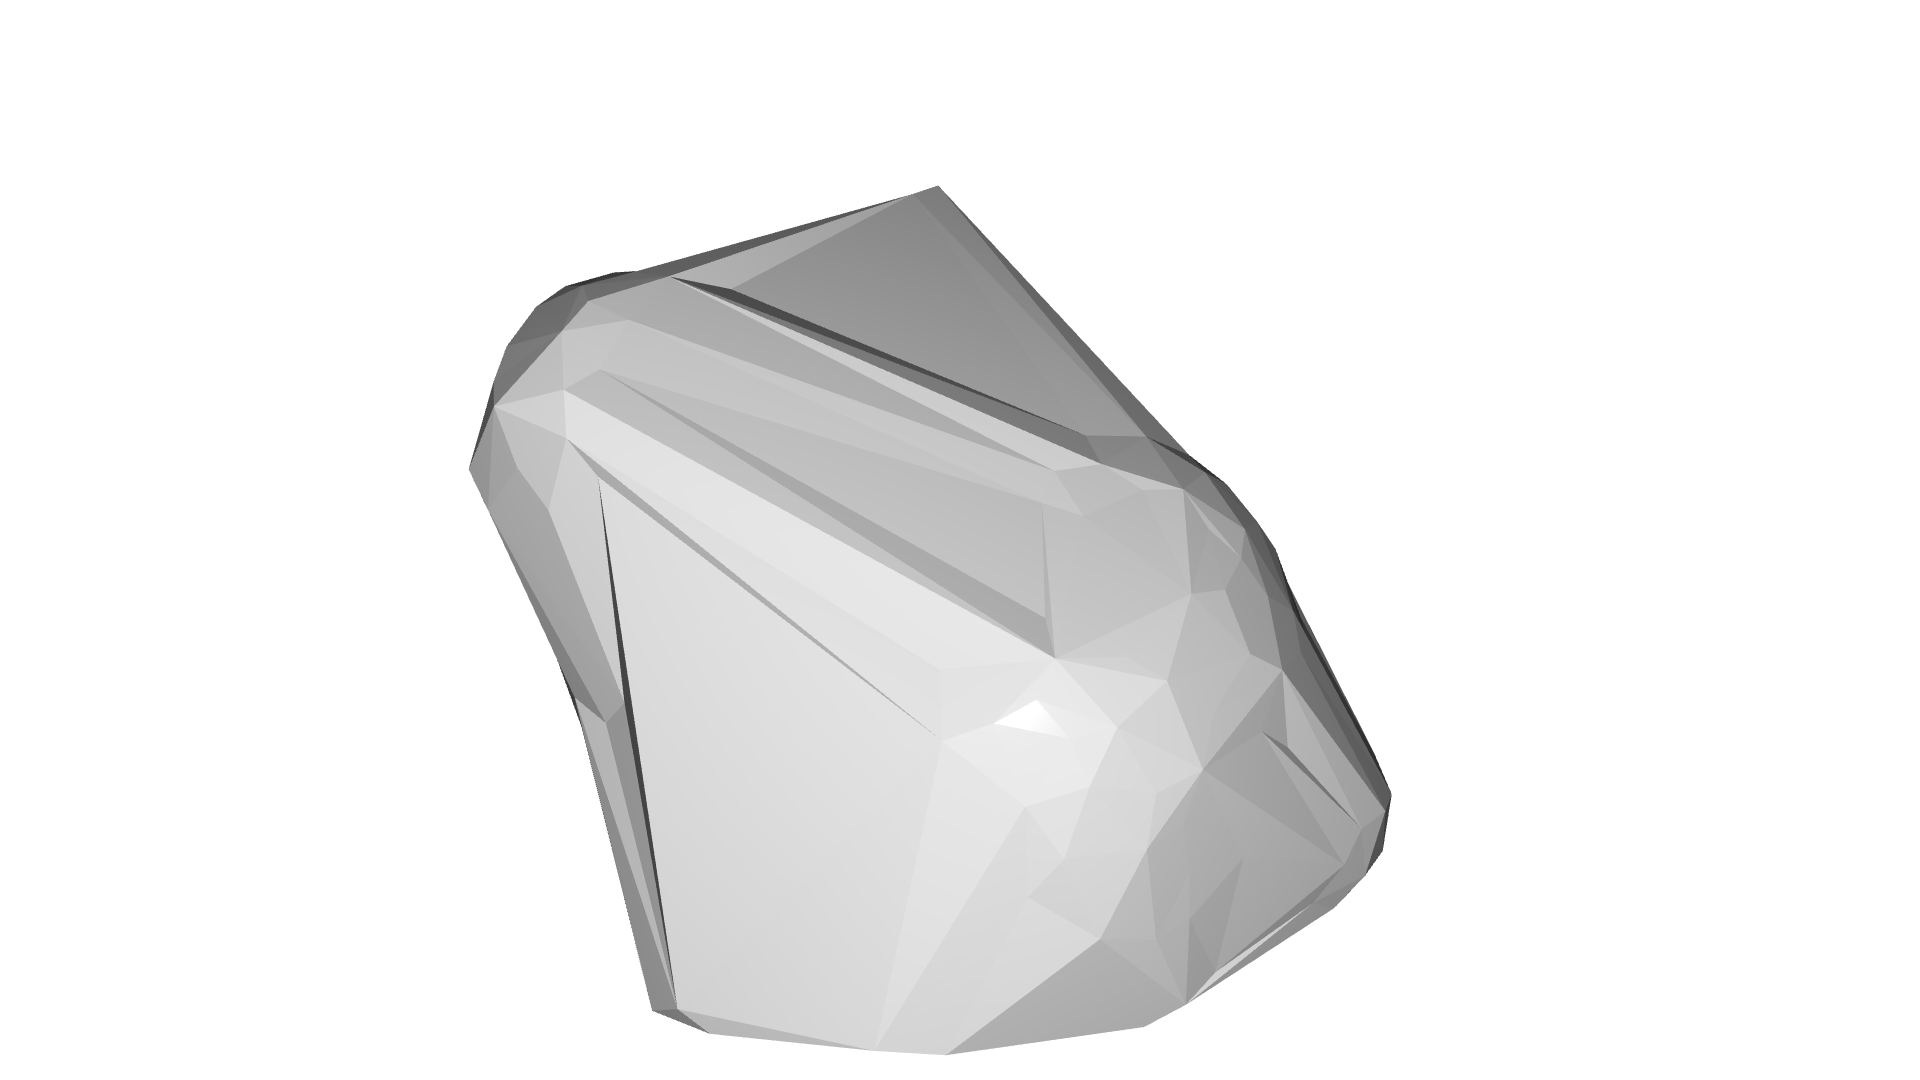

alpha=0.037


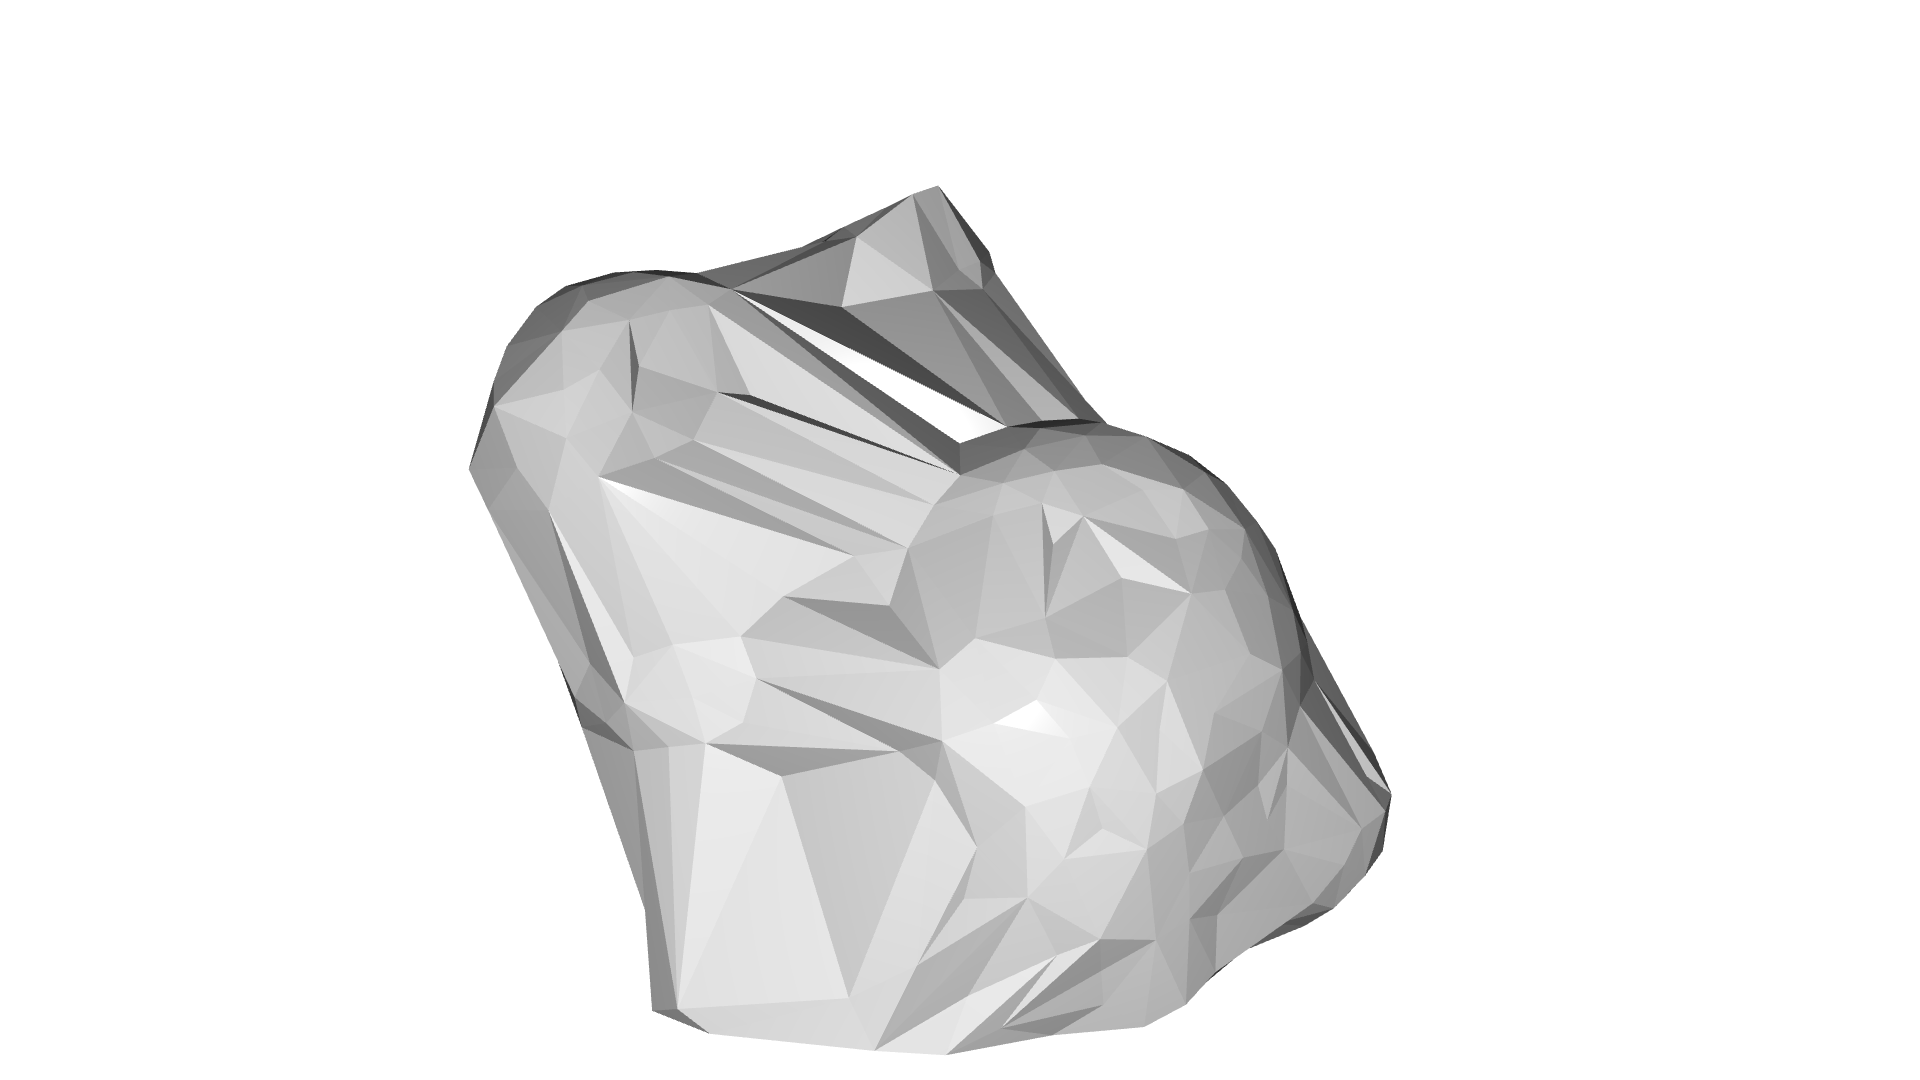

alpha=0.010


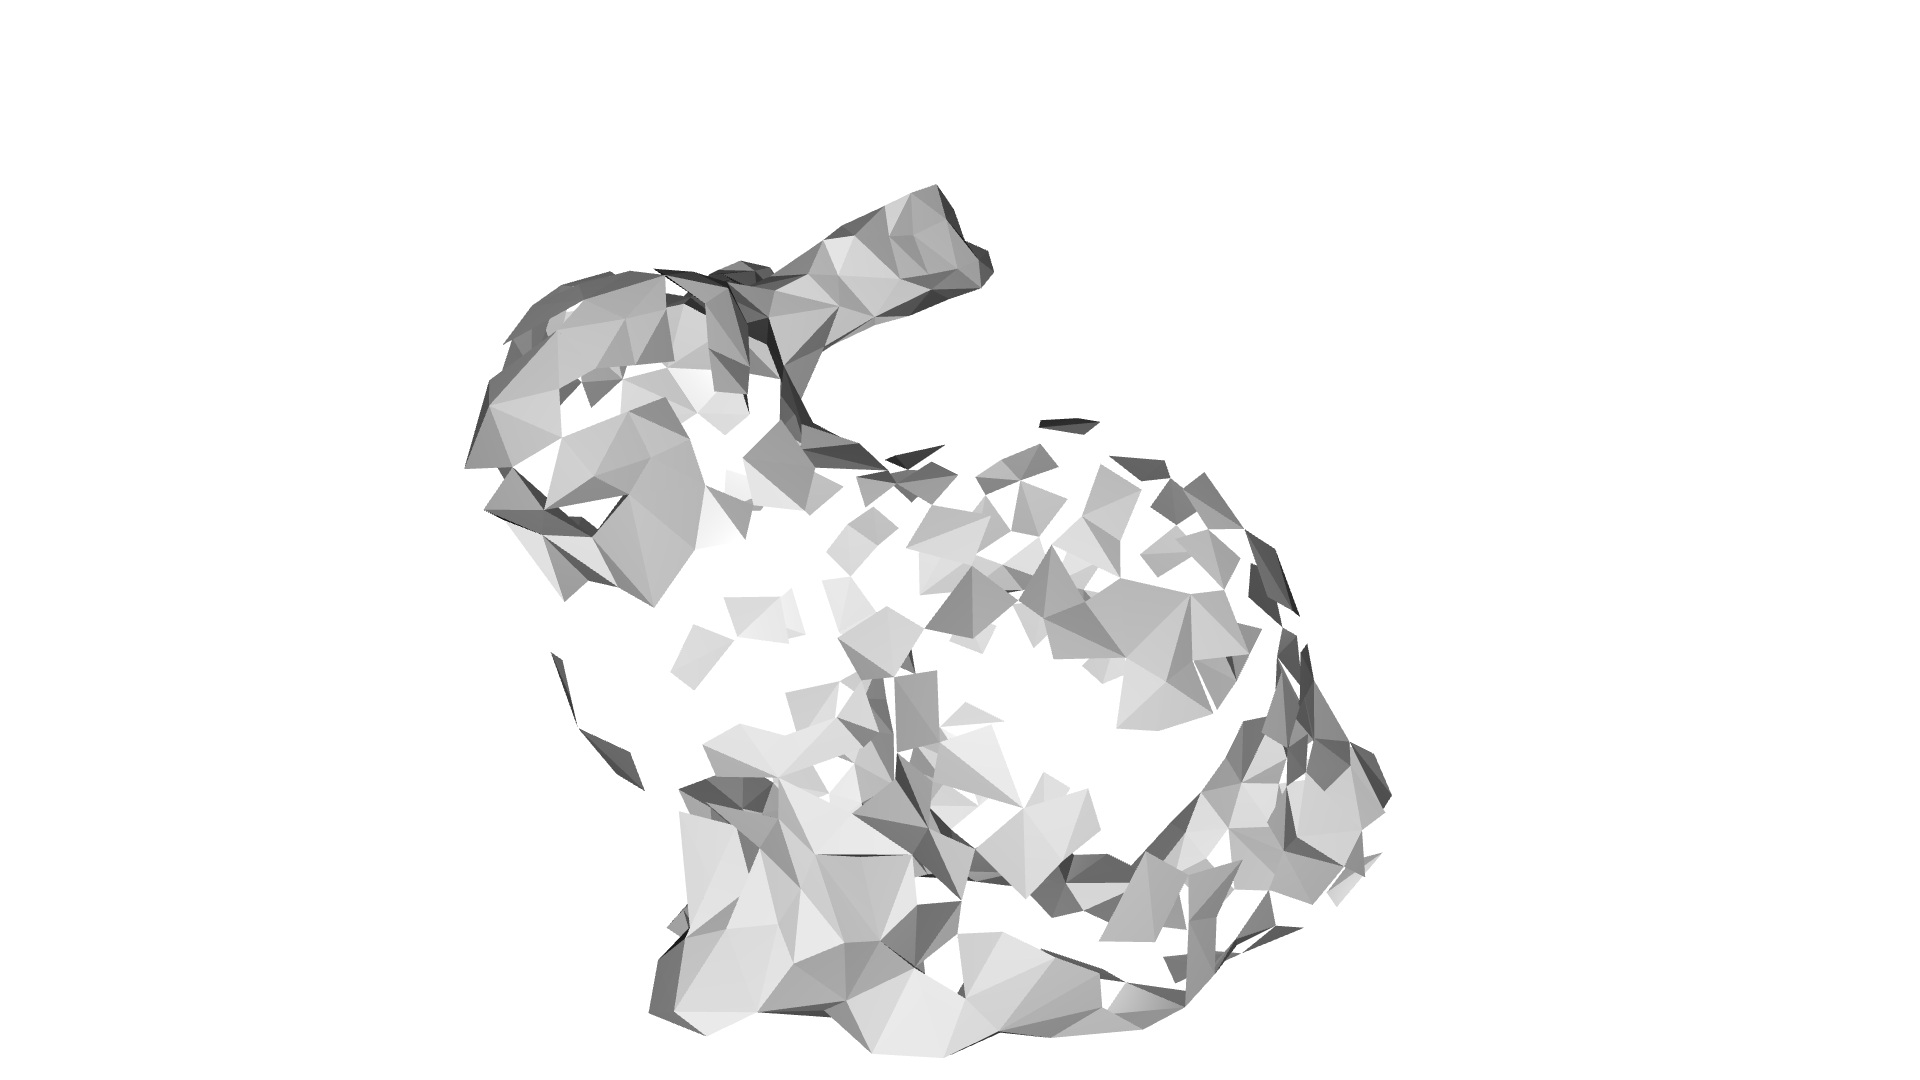

In [3]:
tetra_mesh, pt_map = o3d.geometry.TetraMesh.create_from_point_cloud(pcd)
for alpha in np.logspace(np.log10(0.5), np.log10(0.01), num=4):
    print(f"alpha={alpha:.3f}")
    mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(
        pcd, alpha, tetra_mesh, pt_map)
    mesh.compute_vertex_normals()
    o3d.visualization.draw_geometries([mesh], mesh_show_back_face=True)

## Ball pivoting
The ball pivoting algorithm (BPA) [\[Bernardini1999\]](../reference.html#Bernardini1999) is a surface reconstruction method which is related to alpha shapes. Intuitively, think of a 3D ball with a given radius that we drop on the point cloud. If it hits any 3 points (and it does not fall through those 3 points) it creates a triangles. Then, the algorithm starts pivoting from the edges of the existing triangles and every time it hits 3 points where the ball does not fall through we create another triangle.

Open3D implements this method in `create_from_point_cloud_ball_pivoting`. The method accepts a list of `radii` as parameter that corresponds to the radii of the individual balls that are pivoted on the point cloud.


<div class="alert alert-info">
    
**Note:** 

This algorithm assumes that the `PointCloud` has `normals`.

</div>

In [4]:
gt_mesh = o3dtut.get_bunny_mesh()
gt_mesh.compute_vertex_normals()
pcd = gt_mesh.sample_points_poisson_disk(3000)
o3d.visualization.draw_geometries([pcd])

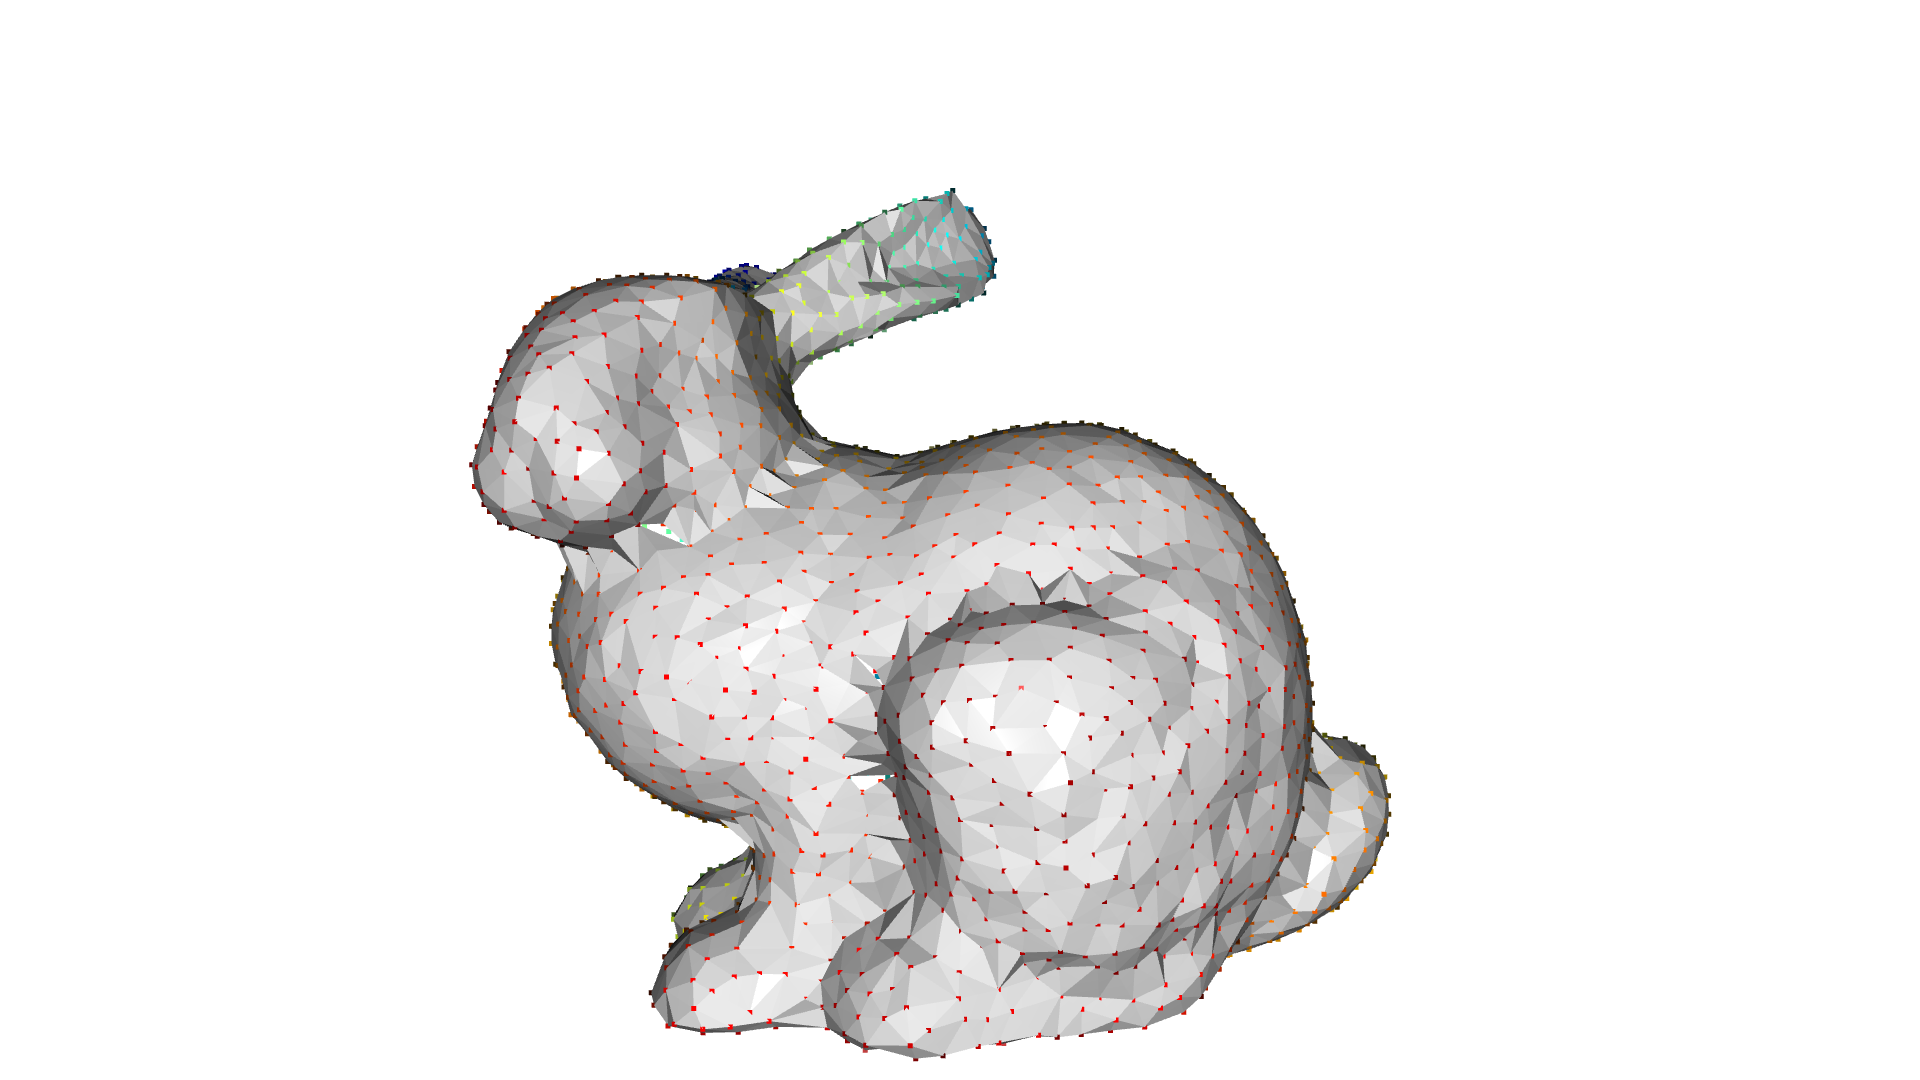

In [5]:
radii = [0.005, 0.01, 0.02, 0.04]
rec_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(
    pcd, o3d.utility.DoubleVector(radii))
o3d.visualization.draw_geometries([pcd, rec_mesh])

## Poisson surface reconstruction
The Poisson surface reconstruction method [\[Kazhdan2006\]](../reference.html#Kazhdan2006) solves a regularized optimization problem to obtain a smooth surface. For this reason, Poisson surface reconstruction can be preferable to the methods mentioned above, as they produce non-smooth results since the points of the `PointCloud` are also the `vertices` of the resulting triangle mesh without any modifications.

Open3D implements the method `create_from_point_cloud_poisson` which is basically a wrapper of the code of [Kazhdan](https://github.com/mkazhdan/PoissonRecon). An important parameter of the function is `depth` that defines the depth of the octree used for the surface reconstruction and hence implies the resolution of the resulting triangle mesh. A higher `depth` value means a mesh with more details.

<div class="alert alert-info">
    
**Note:** 

This algorithm assumes that the `PointCloud` has `normals`.

</div>

downloading eagle pcl
PointCloud with 796825 points.


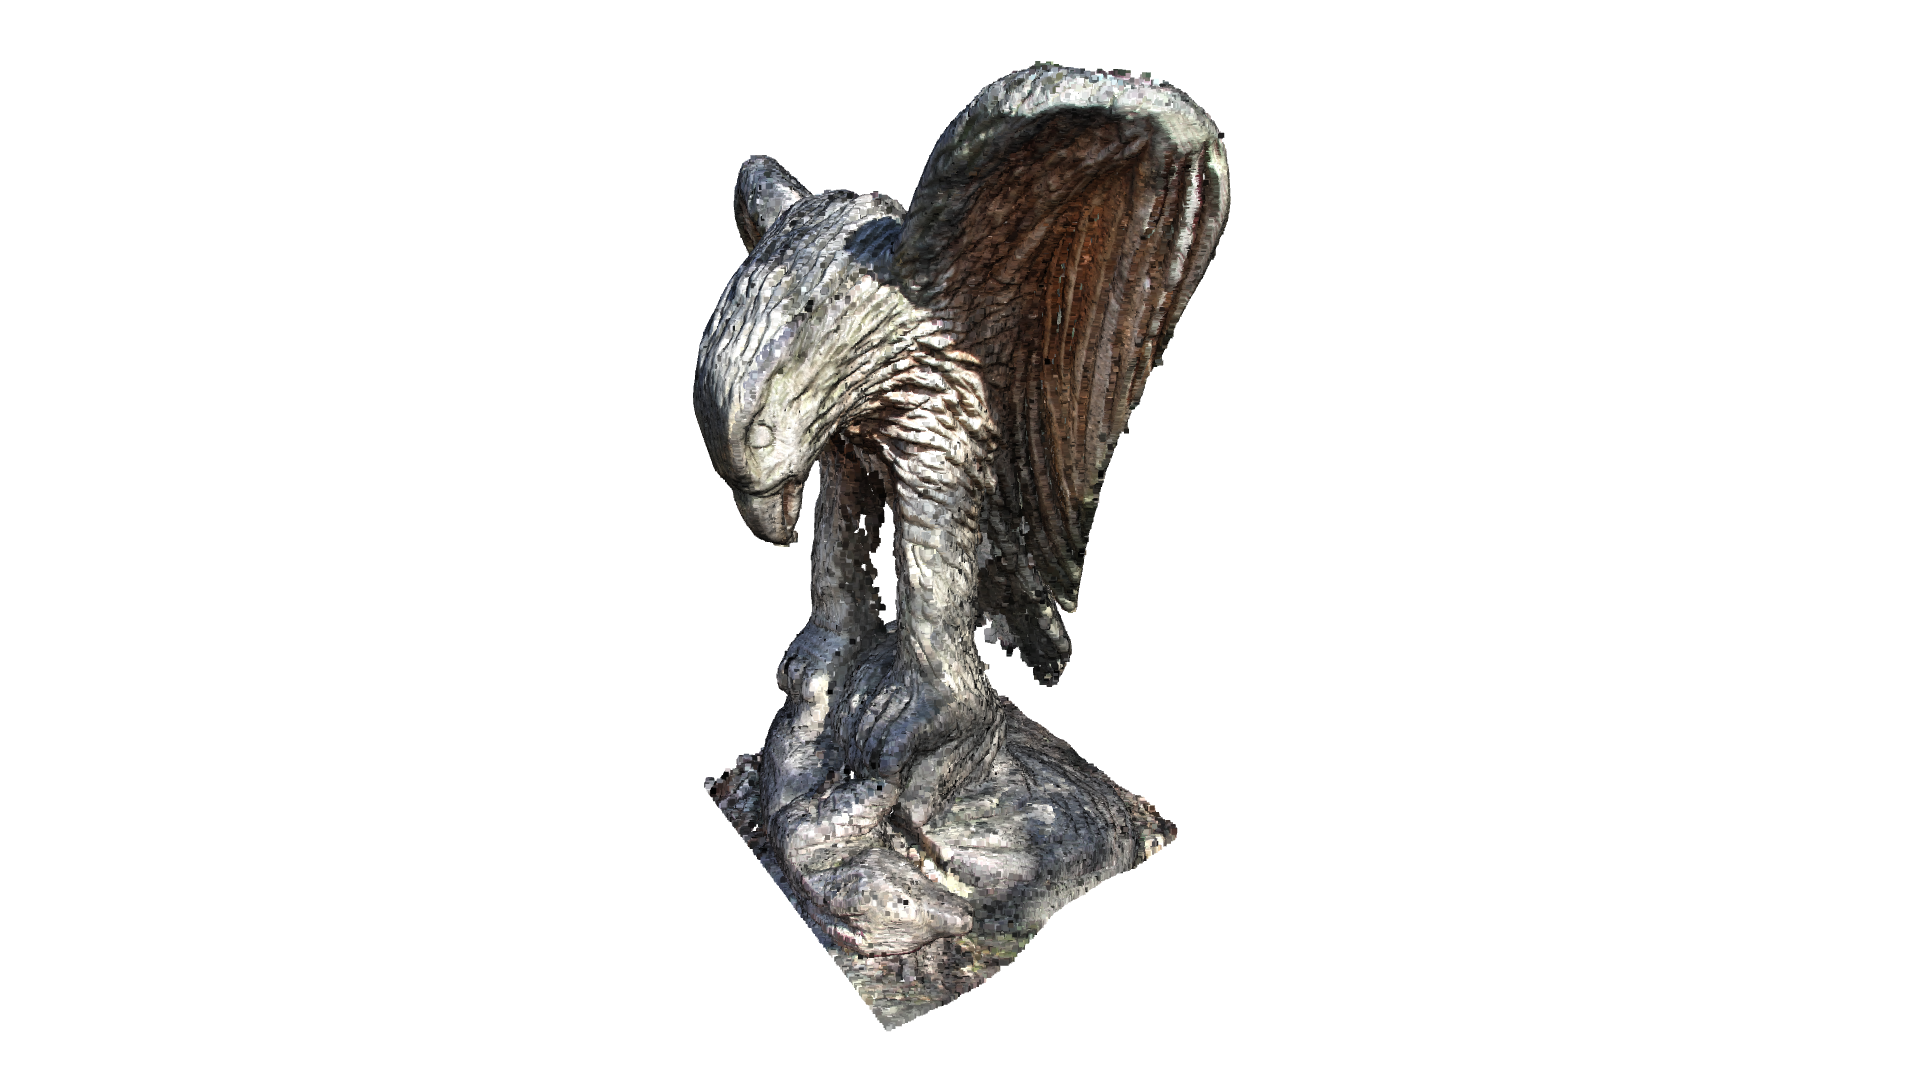

In [6]:
pcd = o3dtut.get_eagle_pcd()
print(pcd)
o3d.visualization.draw_geometries([pcd],
                                  zoom=0.664,
                                  front=[-0.4761, -0.4698, -0.7434],
                                  lookat=[1.8900, 3.2596, 0.9284],
                                  up=[0.2304, -0.8825, 0.4101])

run Poisson surface reconstruction
[Open3D DEBUG] Input Points / Samples: 796825 / 368254
[Open3D DEBUG] #   Got kernel density: 0.0841351 (s), 360.074 (MB) / 360.074 (MB) / 360 (MB)
[Open3D DEBUG] #     Got normal field: 0.484341 (s), 455.98 (MB) / 455.98 (MB) / 455 (MB)
[Open3D DEBUG] Point weight / Estimated Area: 2.623551e-06 / 2.090511e+00
[Open3D DEBUG] #       Finalized tree: 0.420643 (s), 574.938 (MB) / 574.938 (MB) / 574 (MB)
[Open3D DEBUG] #  Set FEM constraints: 0.561684 (s), 535.098 (MB) / 574.938 (MB) / 574 (MB)
[Open3D DEBUG] #Set point constraints: 0.160474 (s), 535.098 (MB) / 574.938 (MB) / 574 (MB)
[Open3D DEBUG] Leaf Nodes / Active Nodes / Ghost Nodes: 2945433 / 3365000 / 1209
[Open3D DEBUG] Memory Usage: 535.098 MB
[Open3D DEBUG] # Linear system solved: 1.5945 (s), 580.988 (MB) / 580.988 (MB) / 580 (MB)
[Open3D DEBUG] Got average: 0.0235858 (s), 532.996 (MB) / 580.988 (MB) / 580 (MB)
[Open3D DEBUG] Iso-Value: 5.028478e-01 = 4.006817e+05 / 7.968250e+05
[Open3D DEBUG] 

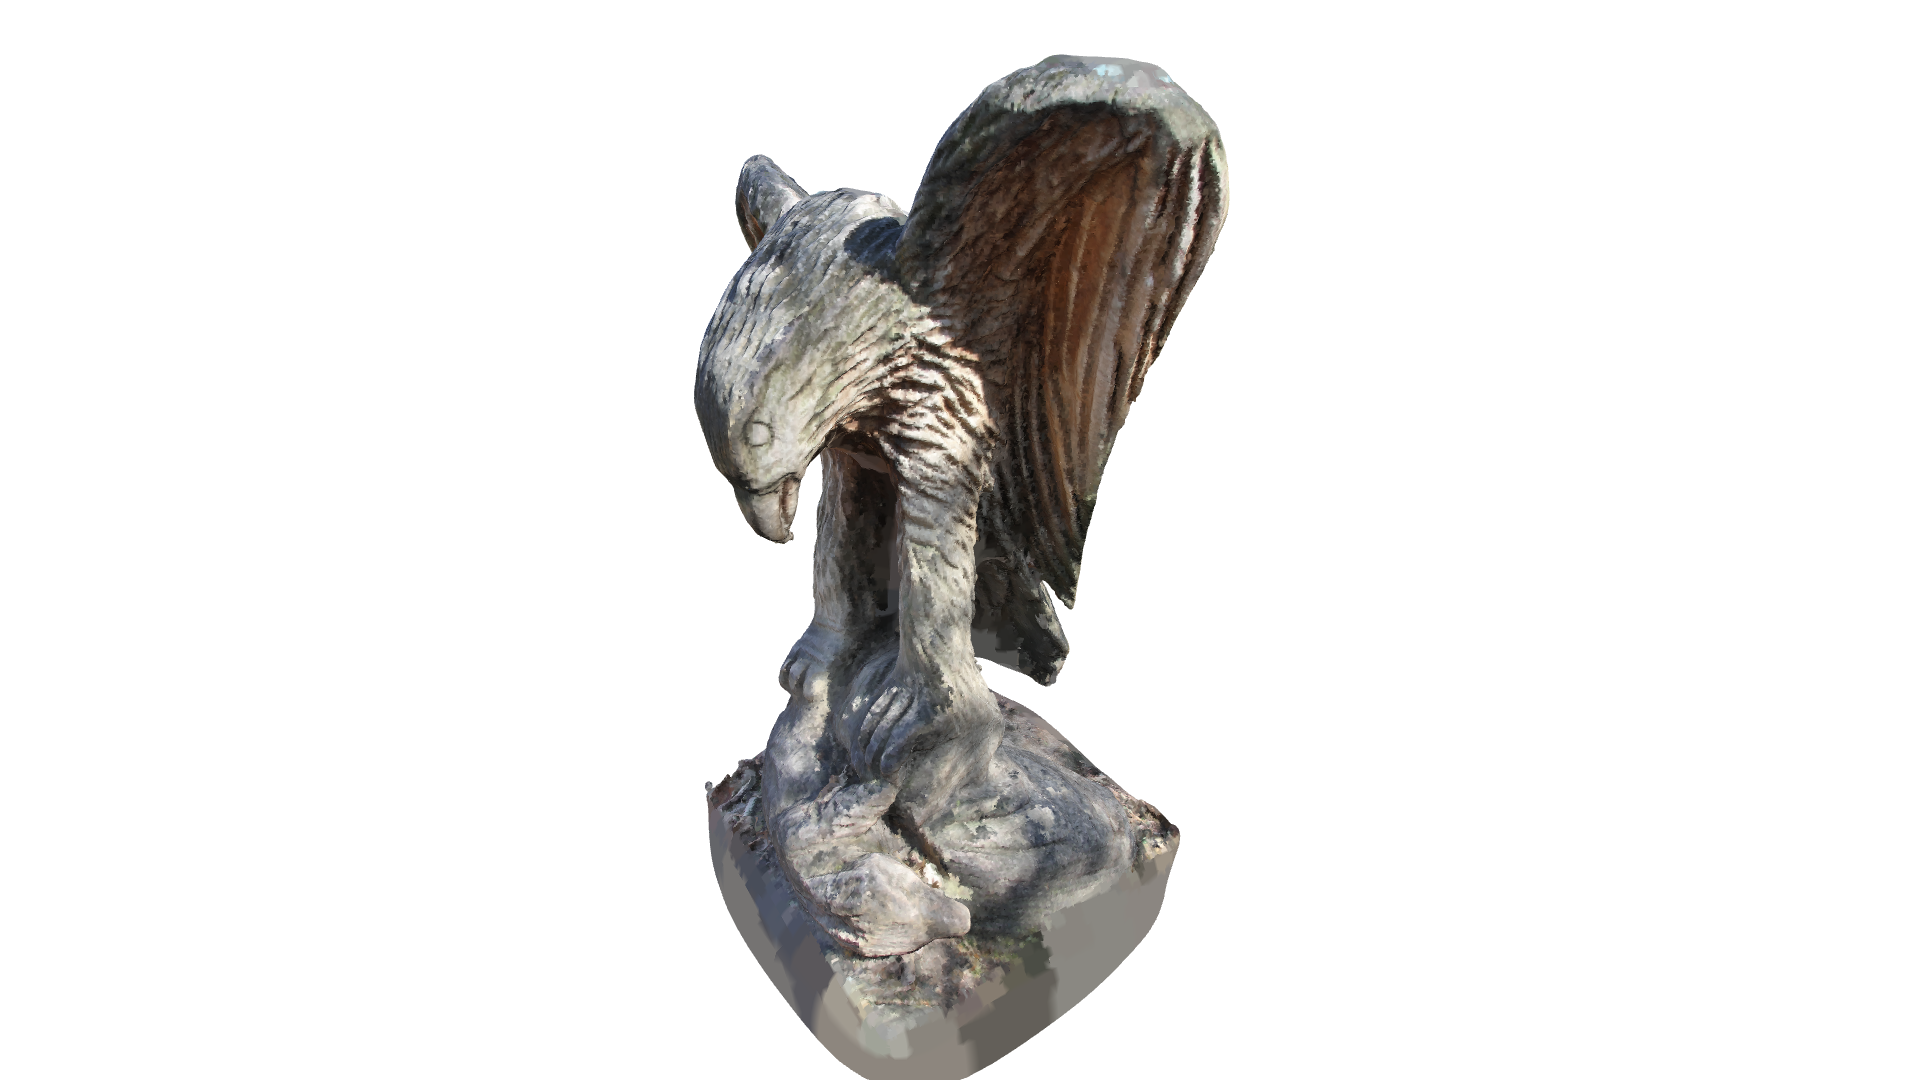

In [7]:
print('run Poisson surface reconstruction')
with o3d.utility.VerbosityContextManager(
        o3d.utility.VerbosityLevel.Debug) as cm:
    mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(
        pcd, depth=9)
print(mesh)
o3d.visualization.draw_geometries([mesh],
                                  zoom=0.664,
                                  front=[-0.4761, -0.4698, -0.7434],
                                  lookat=[1.8900, 3.2596, 0.9284],
                                  up=[0.2304, -0.8825, 0.4101])

Poisson surface reconstruction will also create triangles in areas of low point density, and even extrapolates into some areas (see bottom of the eagle output above). The `create_from_point_cloud_poisson` function has a second `densities` return value that indicates for each vertex the density. A low density value means that the vertex is only supported by a low number of points from the input point cloud.

In the code below we visualize the density in 3D using pseudo color. Violet indicates low density and yellow indicates a high density.

visualize densities


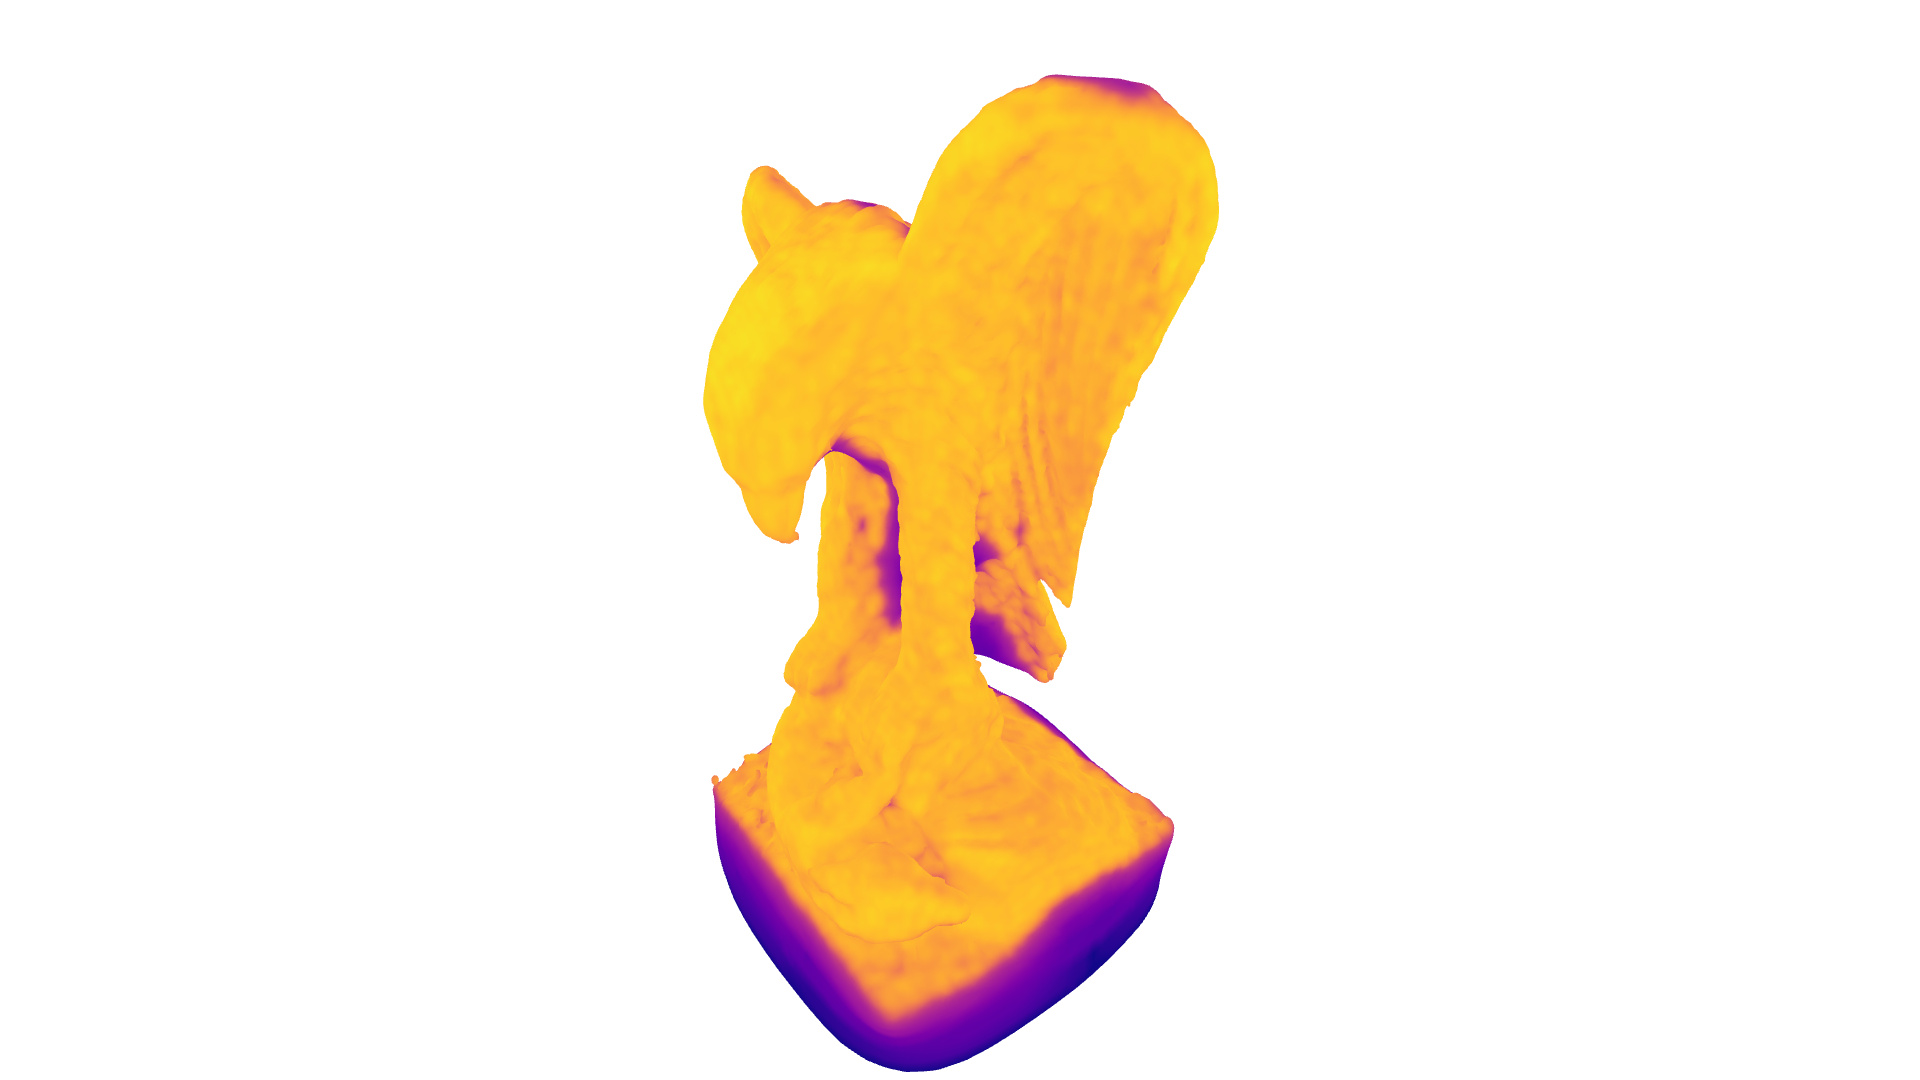

In [8]:
print('visualize densities')
densities = np.asarray(densities)
density_colors = plt.get_cmap('plasma')(
    (densities - densities.min()) / (densities.max() - densities.min()))
density_colors = density_colors[:, :3]
density_mesh = o3d.geometry.TriangleMesh()
density_mesh.vertices = mesh.vertices
density_mesh.triangles = mesh.triangles
density_mesh.triangle_normals = mesh.triangle_normals
density_mesh.vertex_colors = o3d.utility.Vector3dVector(density_colors)
o3d.visualization.draw_geometries([density_mesh],
                                  zoom=0.664,
                                  front=[-0.4761, -0.4698, -0.7434],
                                  lookat=[1.8900, 3.2596, 0.9284],
                                  up=[0.2304, -0.8825, 0.4101])

We can further use the density values to remove vertices and triangles that have a low support. In the code below we remove all vertices (and connected triangles) that have a lower density value than the $0.01$ quantile of all density values.

remove low density vertices
TriangleMesh with 557480 points and 1113212 triangles.


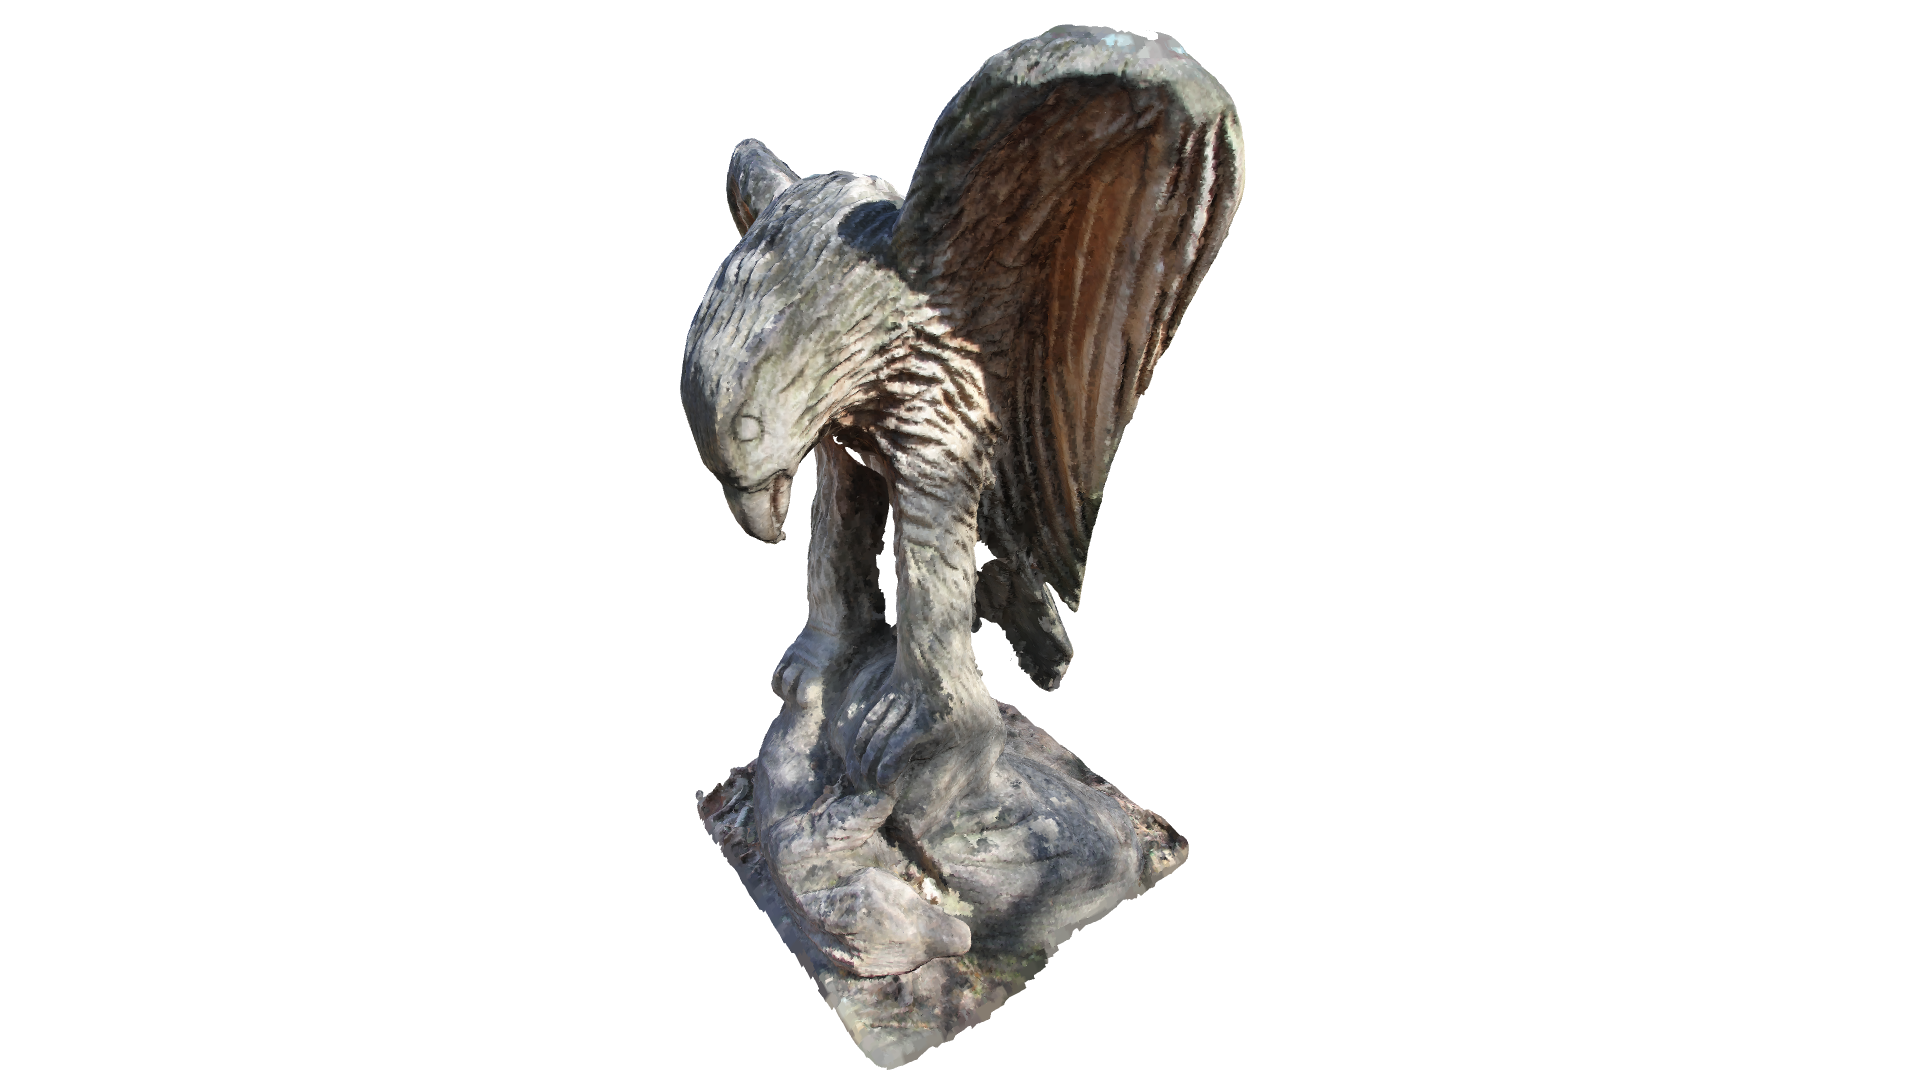

In [9]:
print('remove low density vertices')
vertices_to_remove = densities < np.quantile(densities, 0.01)
mesh.remove_vertices_by_mask(vertices_to_remove)
print(mesh)
o3d.visualization.draw_geometries([mesh],
                                  zoom=0.664,
                                  front=[-0.4761, -0.4698, -0.7434],
                                  lookat=[1.8900, 3.2596, 0.9284],
                                  up=[0.2304, -0.8825, 0.4101])

## Normal estimation
In the examples above we assumed that the point cloud has normals that point outwards. However, not all point clouds already come with associated normals. Open3D can be used to estimate point cloud normals with `estimate_normals`, which locally fits a plane per 3D point to derive the normal. However, the estimated normals might not be consistently oriented. `orient_normals_consistent_tangent_plane` propagates the normal orientation using a minimum spanning tree.

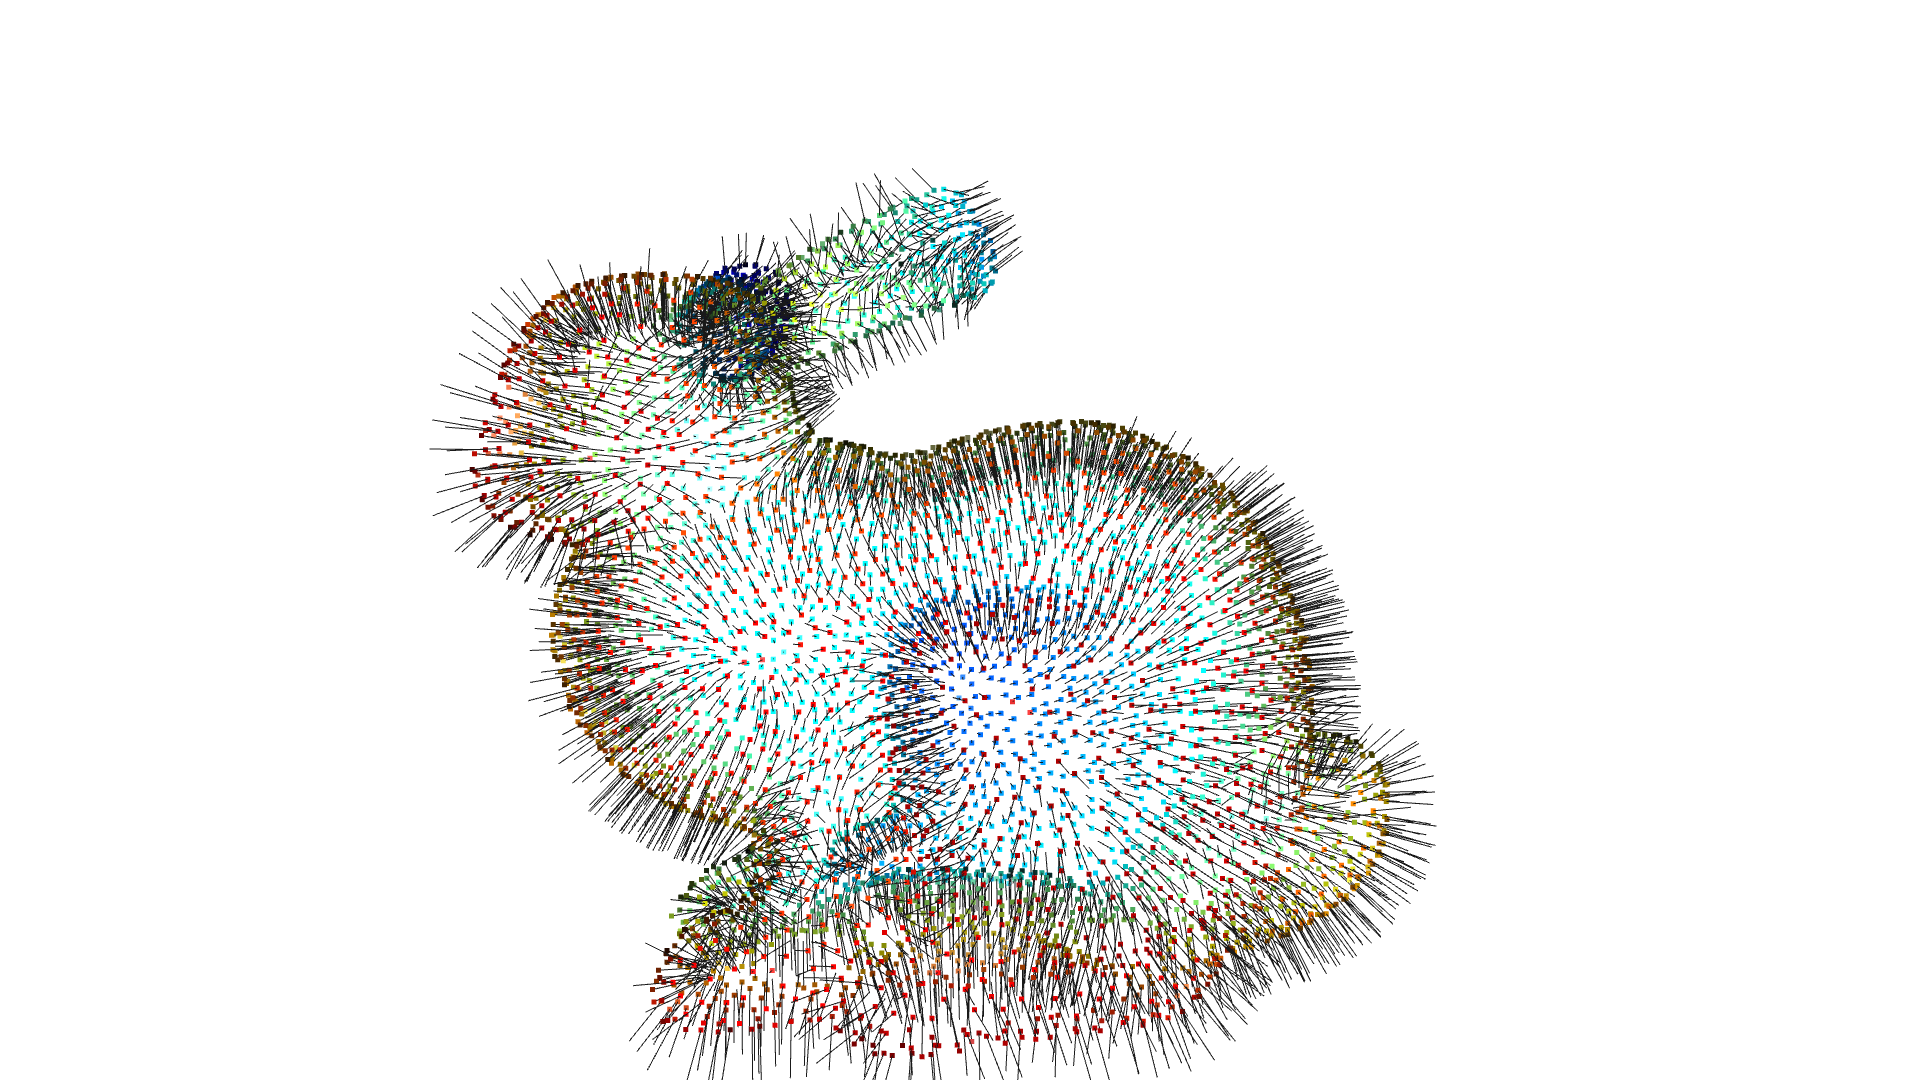

In [10]:
gt_mesh = o3dtut.get_bunny_mesh()
pcd = gt_mesh.sample_points_poisson_disk(5000)
pcd.normals = o3d.utility.Vector3dVector(np.zeros(
    (1, 3)))  # invalidate existing normals

pcd.estimate_normals()
o3d.visualization.draw_geometries([pcd], point_show_normal=True)

In [11]:
pcd.orient_normals_consistent_tangent_plane(100)
o3d.visualization.draw_geometries([pcd], point_show_normal=True)